# Preprocessing i klasyfikacja wieloklasowa

Dla tokenizacji i normalizacji tekstu wykorzystamy pakiet `spacy`.

In [1]:
import helper as h
from scikitplot.metrics import plot_confusion_matrix
import pandas as pd
import numpy as np

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from html import unescape

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nlp = spacy.load("en_core_web_sm")

#### <b>Wczytajmy dane ;-)</b>

In [3]:
df = pd.read_hdf("./tweets_airline.h5")

print(df.shape)
df.sample(5)

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13124,569934457215410176,neutral,1.0000,unknown,NaN,American,NaN,TheAdamRizz,NaN,0,"@AmericanAir Hahaha.... ""Meanwhile in Russia....""",NaN,2015-02-23 10:58:58 -0800,"Dallas, Texas",Pacific Time (US & Canada)
11807,567747769176432640,negative,1.0000,Cancelled Flight,0.6474,US Airways,NaN,cnichols9,NaN,0,@USAirways Travelling from pwm to atl on Sunda...,NaN,2015-02-17 10:09:51 -0800,Georgia,NaN
10269,569419080479875072,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,bgarritty,NaN,0,@USAirways 2 hours on hold. Still no answer. H...,NaN,2015-02-22 00:51:02 -0800,"Adelaide, Australia",Adelaide
11994,570275010759102466,negative,1.0000,Lost Luggage,1.0000,American,NaN,paintbranch1398,NaN,0,@AmericanAir this delayed bag was for my frien...,NaN,2015-02-24 09:32:12 -0800,NaN,NaN
336,568579880046227457,neutral,0.6703,unknown,NaN,Virgin America,NaN,FreyaBevan_Fund,NaN,1,@VirginAmerica Many Thanks for the Follow.\n#o...,NaN,2015-02-19 17:16:21 -0800,freyabevanfund@hotmail.com,NaN


Sprawdźmy, jakich firm to dotyczy.

In [4]:
df['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

Zmienna docelowa:

In [5]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Jak widać, mamy ponad 9 tys. negatywnych opinii i tylko 2363 pozytywnych. Co jest dość naturalne ... bo zwykle niezadowolony wkurzony klient opowie o 10 osobom, a zadowolony tylko jednej. Ta proporcja jest tu zauważalna.

Zamiast konwertować opinię do dwu klas (`negative` i `positive`) pozostaniemy przy 3, a <b>3 implikuje chaos ...</b> :-)

In [6]:
df['airline_sentiment_target'], labels = df['airline_sentiment'].factorize()

## Base Line

Zacznijmy jak "najszybciej" od uzyskania wyników, aby móc porównywać, na ile nasze zmiany są pomocne. Dlatego nie róbmy żadnego "preprocessing" i użyjmy najprostszego `vectorizer`, czyli `CountVectorizer`.

Trenujemy model i sprawdzamy wynik.

In [7]:
X = df['text'].values
y = df['airline_sentiment_target'].values

tokens #20: ['americanair' 'and' 'flight' 'for' 'in' 'is' 'it' 'jetblue' 'me' 'my'
 'of' 'on' 'southwestair' 'that' 'the' 'to' 'united' 'usairways' 'you'
 'your']
model=dummy, f1_micro: mean=0.47, std=0.0
model=svm, f1_micro: mean=0.65, std=0.0
model=naive bayes, f1_micro: mean=0.63, std=0.0
model=decision tree, f1_micro: mean=0.63, std=0.0
model=random forest, f1_micro: mean=0.63, std=0.0
model=xgboost, f1_micro: mean=0.65, std=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 20
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.824037
[LightGBM] [Info] Start training from score -0.466894
[LightGBM] [Warning] No further splits with positiv

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model=catboost, f1_micro: mean=0.65, std=0.0


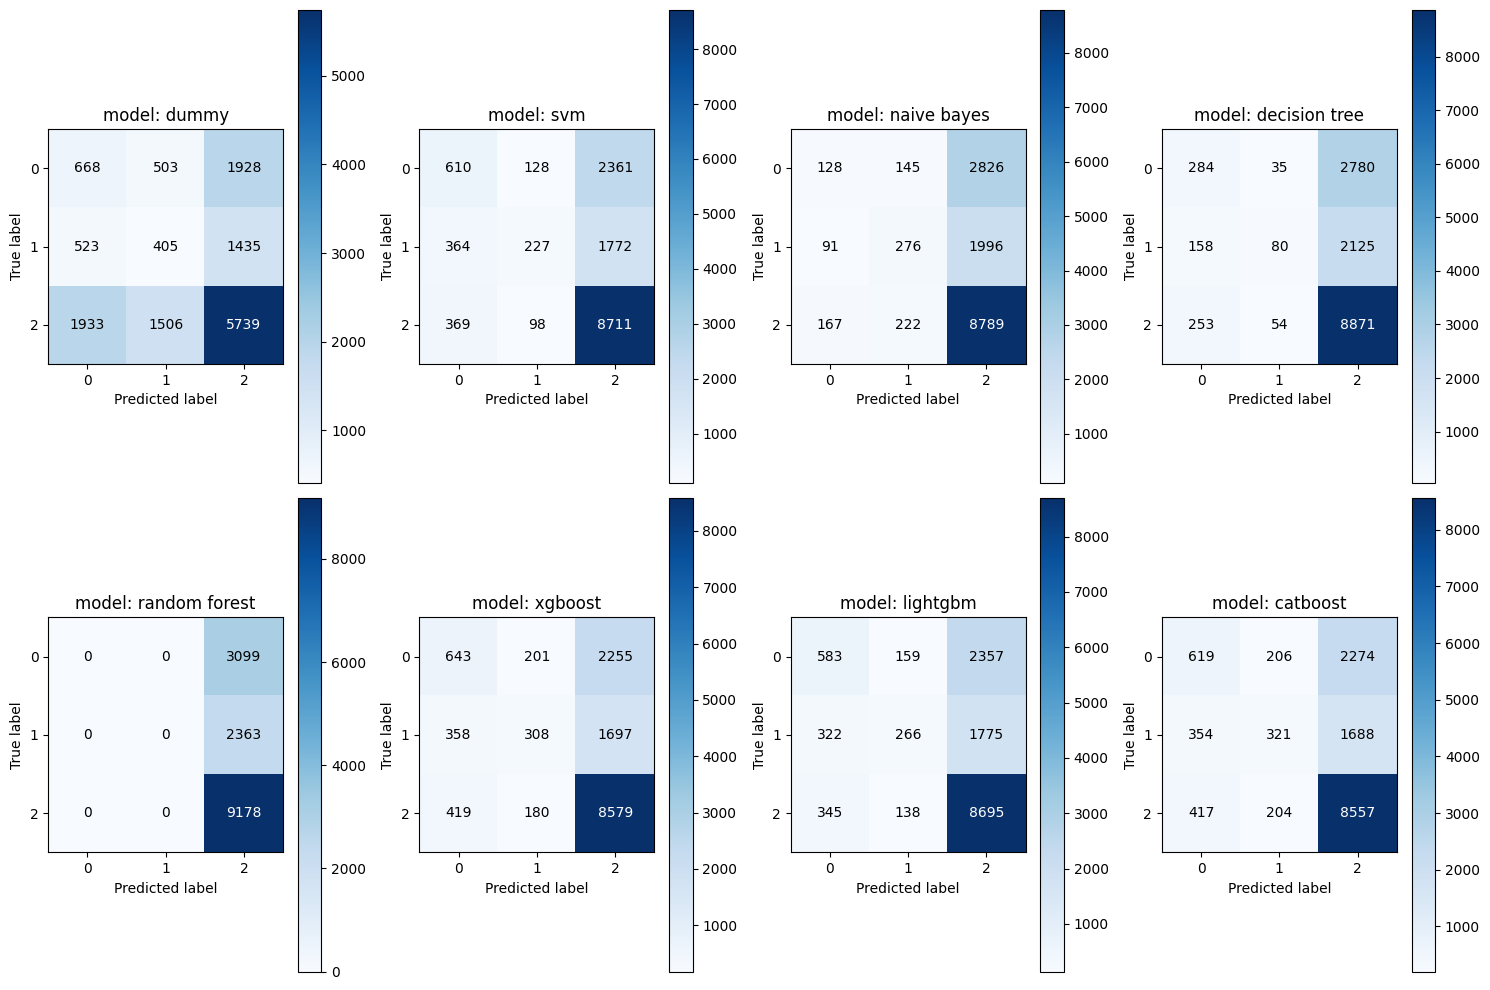

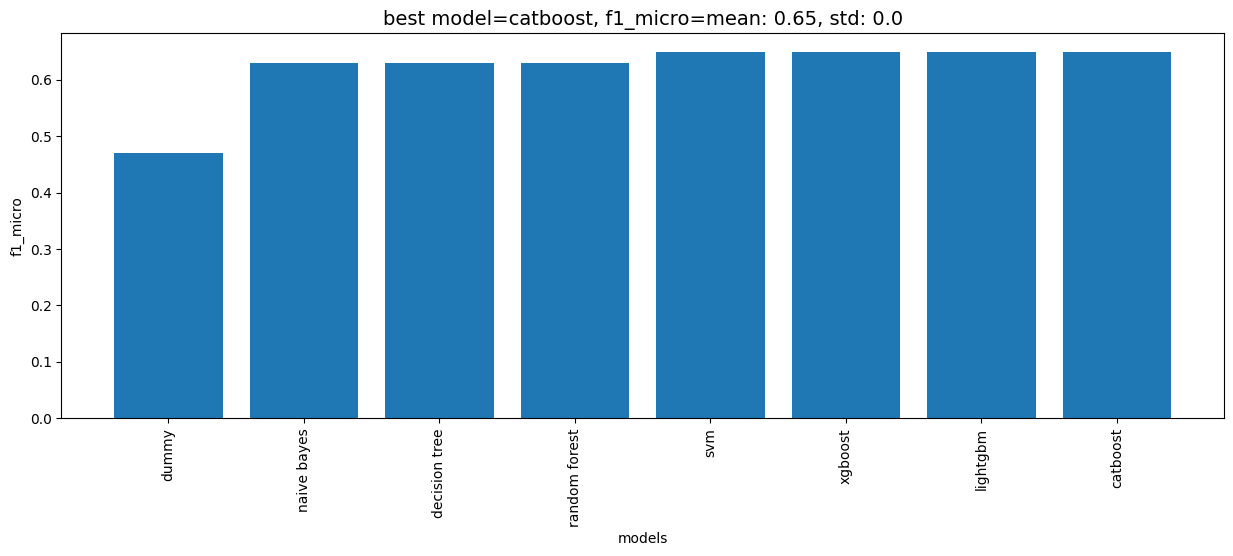

In [8]:
vectorizer_kwargs={'max_features':20}
kwargs = {'scoring': 'f1_micro'}

h.use_vectorizer_and_run_models(X, y, CountVectorizer, vectorizer_kwargs, kwargs)

W tym przypadku bierzemy pod uwagę 20 tokenów `{'max_features':20}`.

```
['americanair', 'and', 'flight', 'for', 'in', 'is', 'it', 'jetblue', 'me', 'my', 'of', 'on', 'southwestair', 'that', 'the', 'to', 'united', 'usairways', 'you', 'your']
```

Cześć z nich to nazwa firm lotniczych: `americanair`, `jetblue`, `southwestair`, `usairways`, `united`. Brakuje jeszcze jednej `Delta` oraz `Virgin America`. Swoją drogą `jetblue` trafiło tu przy okazji ;).

Są też ogólne słowa, takie jak: `and`, `for`, `in`, `is`, `it`. Owszem te słowa są często używane, ale czy wnoszą znaczącą informację? Zwiększmy liczbę tokenów do 100 (`'max_features':100`).


tokens #100: ['about' 'after' 'again' 'airline' 'all' 'am' 'americanair' 'amp' 'an'
 'and' 'any' 'are' 'as' 'at' 'back' 'bag' 'be' 'been' 'but' 'by' 'call'
 'can' 'cancelled' 'co' 'customer' 'delayed' 'do' 'don' 'flight'
 'flightled' 'flights' 'for' 'from' 'gate' 'get' 'got' 'had' 'has' 'have'
 'help' 'hold' 'hour' 'hours' 'how' 'http' 'if' 'in' 'is' 'it' 'jetblue'
 'just' 'late' 'like' 'me' 'more' 'my' 'need' 'no' 'not' 'now' 'of' 'on'
 'one' 'or' 'our' 'out' 'over' 'phone' 'plane' 'please' 'service' 'so'
 'southwestair' 'still' 'thank' 'thanks' 'that' 'the' 'there' 'they'
 'this' 'time' 'to' 'today' 'united' 'up' 'us' 'usairways' 've'
 'virginamerica' 'was' 'we' 'what' 'when' 'why' 'will' 'with' 'would'
 'you' 'your']
model=dummy, f1_micro: mean=0.47, std=0.0
model=svm, f1_micro: mean=0.74, std=0.0
model=naive bayes, f1_micro: mean=0.71, std=0.0
model=decision tree, f1_micro: mean=0.68, std=0.0
model=random forest, f1_micro: mean=0.67, std=0.0
model=xgboost, f1_micro: mean=0.73, std=

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 100
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.823402
[LightGBM] [Info] Start training from score -0.467057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 100
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.824037
[LightGBM] [Info] Start training from score -0.466894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model=catboost, f1_micro: mean=0.73, std=0.0


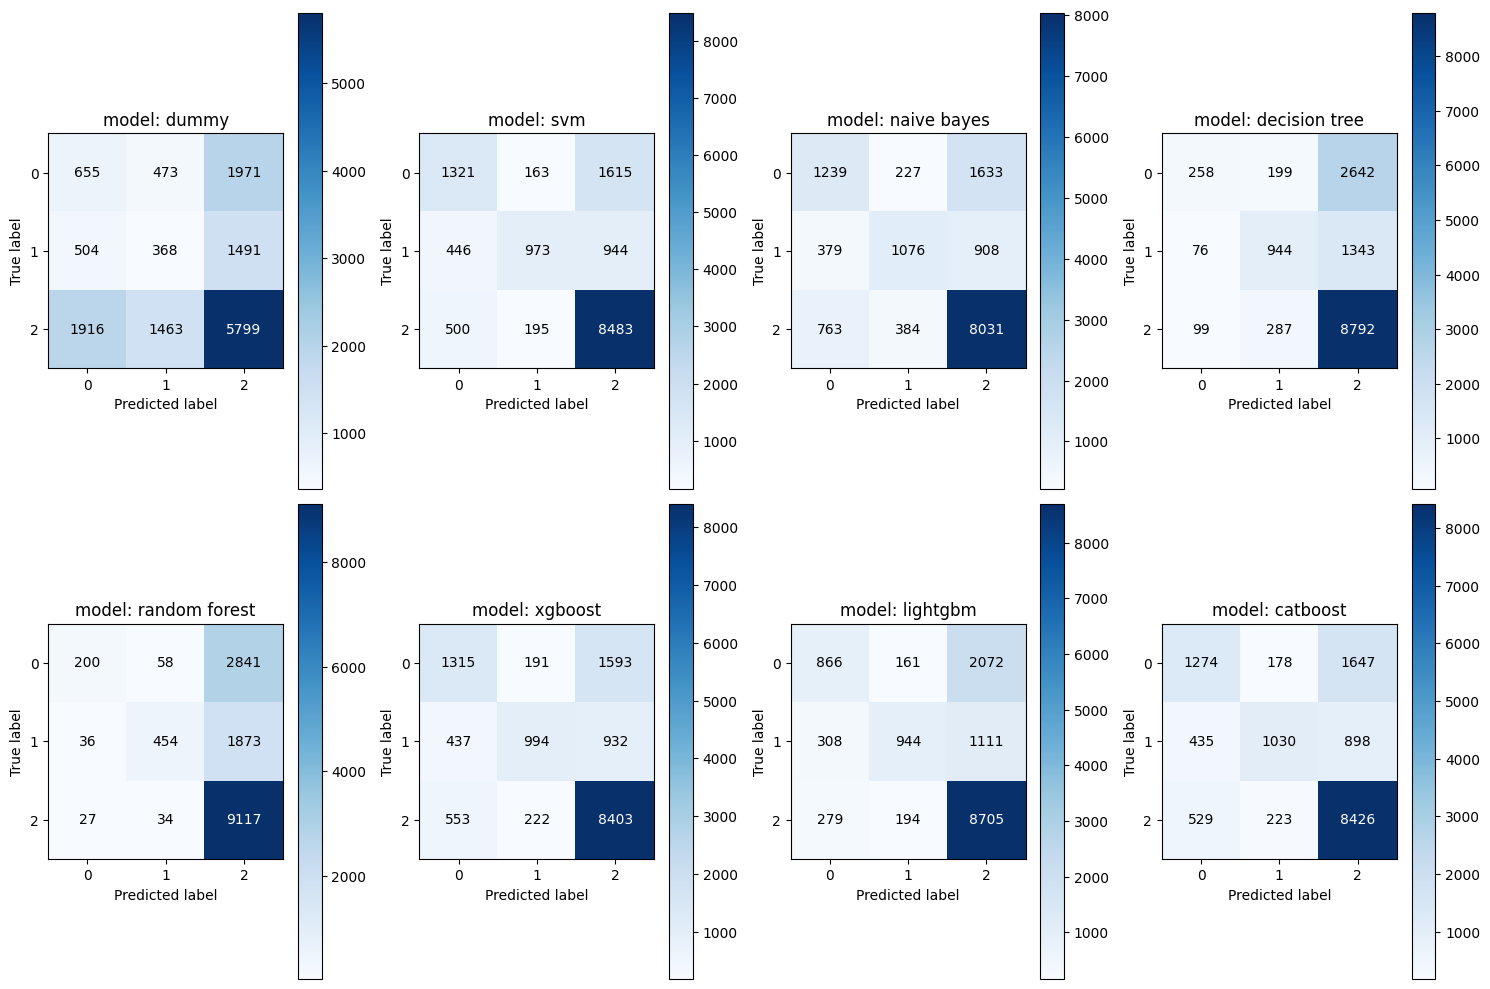

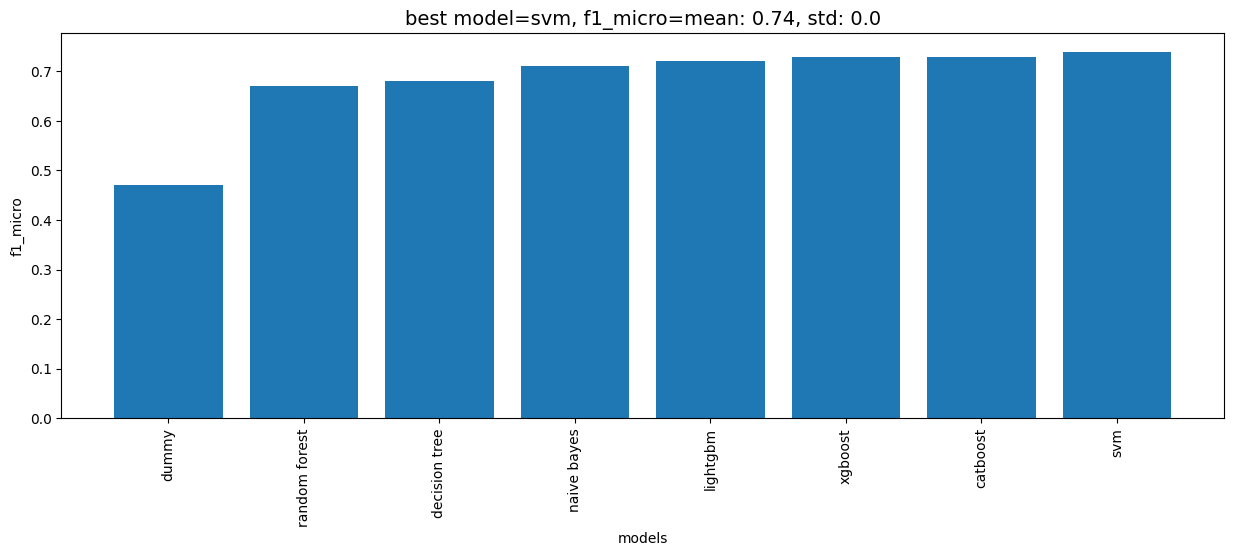

In [9]:
vectorizer_kwargs={'max_features': 100}
kwargs = {'scoring': 'f1_micro'}

h.use_vectorizer_and_run_models(X, y, CountVectorizer, vectorizer_kwargs, kwargs)

Wynik nam znacząco sie poprawił. Mamy już `f1_micro=74%`. Tym razem zwyciężył `svm`. Spróbujmy teraz użyć `tf-idf`.

Te tokeny, zostały użyte:
```
['about', 'after', 'again', 'airline', 'all', 'am', 'americanair', 'amp', 'an', 'and', 'any', 'are', 'as', 'at', 'back', 'bag', 'be', 'been', 'but', 'by', 'call', 'can', 'cancelled', 'co', 'customer', 'delayed', 'do', 'don', 'flight', 'flightled', 'flights', 'for', 'from', 'gate', 'get', 'got', 'had', 'has', 'have', 'help', 'hold', 'hour', 'hours', 'how', 'http', 'if', 'in', 'is', 'it', 'jetblue', 'just', 'late', 'like', 'me', 'more', 'my', 'need', 'no', 'not', 'now', 'of', 'on', 'one', 'or', 'our', 'out', 'over', 'phone', 'plane', 'please', 'service', 'so', 'southwestair', 'still', 'thank', 'thanks', 'that', 'the', 'there', 'they', 'this', 'time', 'to', 'today', 'united', 'up', 'us', 'usairways', 've', 'virginamerica', 'was', 'we', 'what', 'when', 'why', 'will', 'with', 'would', 'you', 'your']
```

Widać np. token `cancelled` (prawdopodobnie występuje głównie w negatywnym wydźwięku).


## Zagadka na dziś [tj. 4 listopada 2025 r.]

Czy `TfidfVectorizer` poradzi sobie lepiej?

_Też warto sprawdzić dwa przypadki np.:`{'max_features':20}` oraz `{'max_features':100}`, aby sprawdzić, czy uzyslujemy poprawę._

tokens #20: ['americanair' 'and' 'flight' 'for' 'in' 'is' 'it' 'jetblue' 'me' 'my'
 'of' 'on' 'southwestair' 'that' 'the' 'to' 'united' 'usairways' 'you'
 'your']
model=dummy, f1_micro: mean=0.46, std=0.0
model=svm, f1_micro: mean=0.65, std=0.0
model=naive bayes, f1_micro: mean=0.63, std=0.0
model=decision tree, f1_micro: mean=0.65, std=0.0
model=random forest, f1_micro: mean=0.64, std=0.0
model=xgboost, f1_micro: mean=0.65, std=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 20
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.824037
[LightGBM] [Info] Start training from score -0.466894
[LightGBM] [Warning] No further splits with posit

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model=lightgbm, f1_micro: mean=0.65, std=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 20
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.824037
[LightGBM] [Info] Start training from score -0.466894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model=catboost, f1_micro: mean=0.65, std=0.0


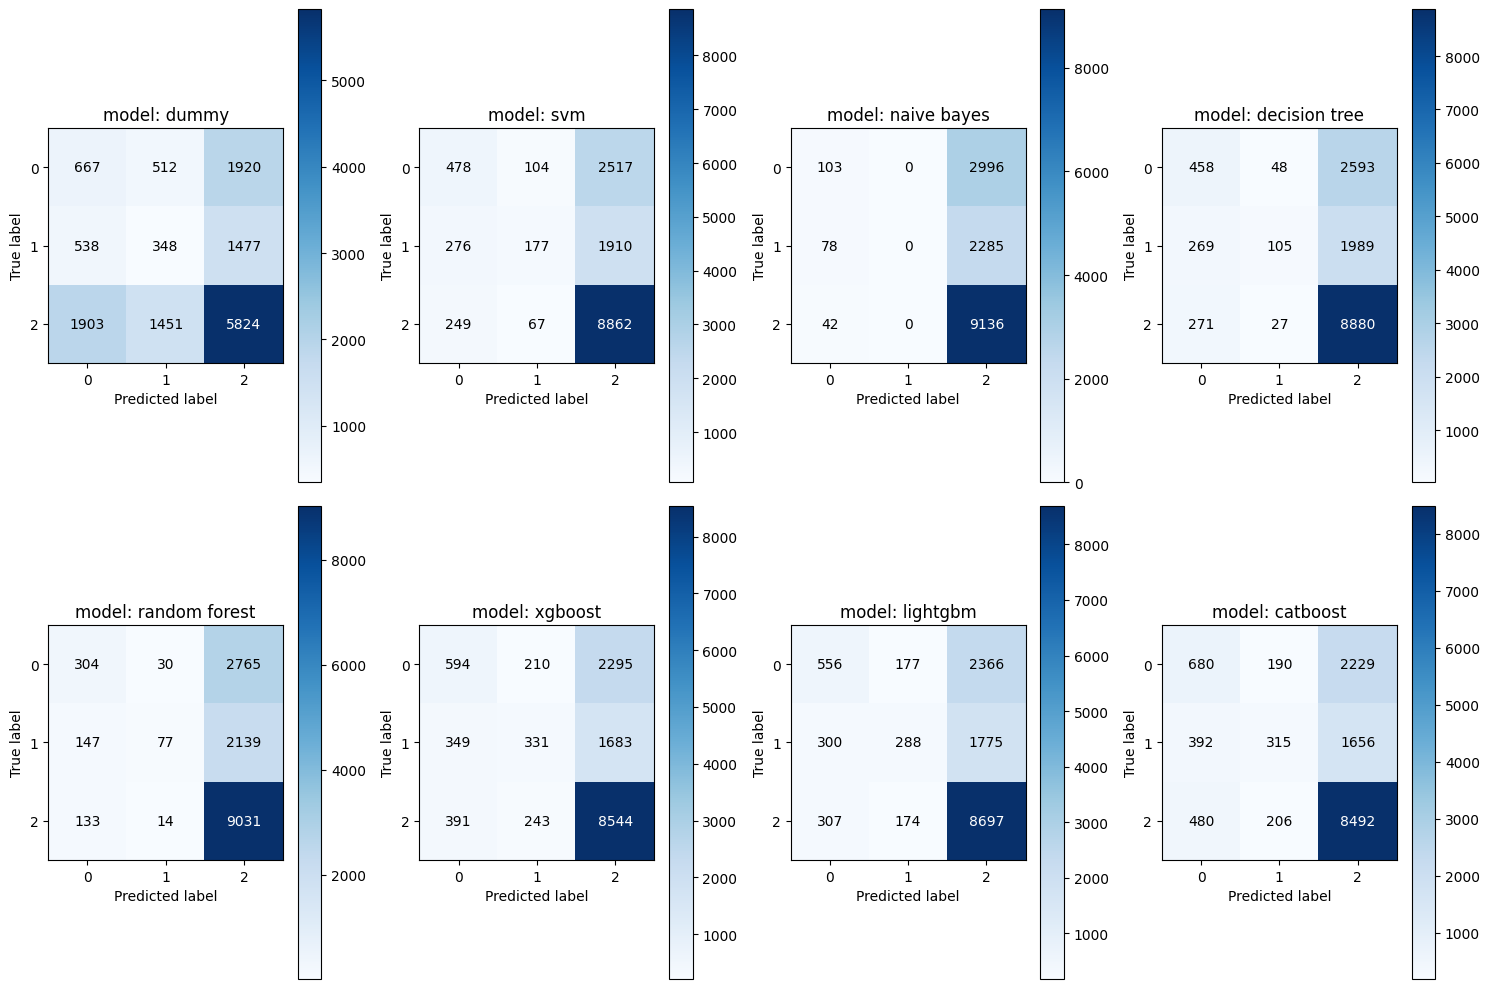

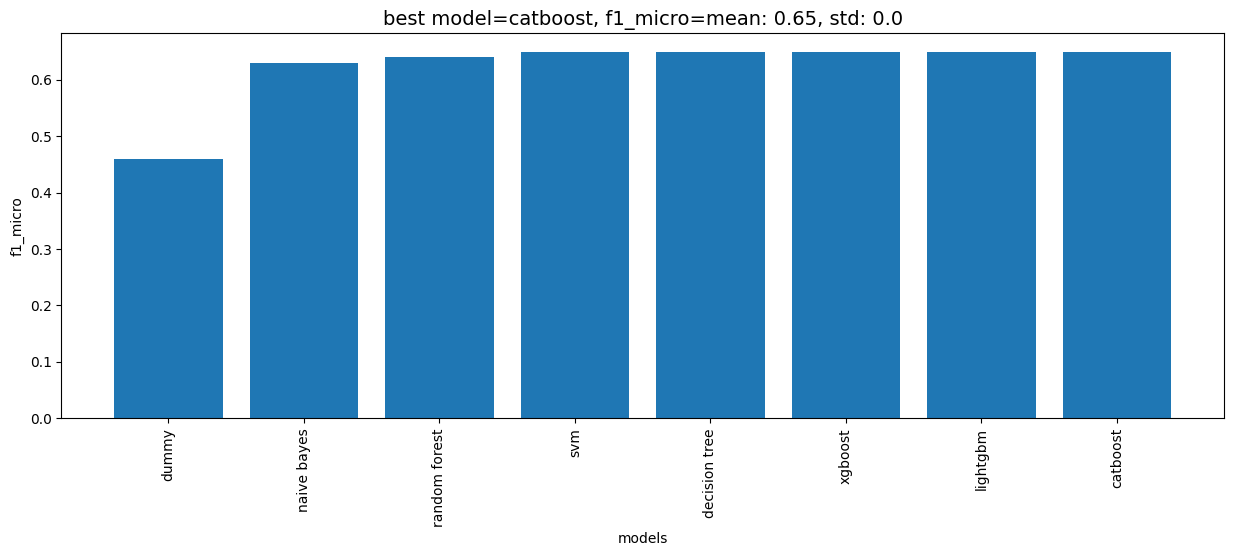

In [10]:
vectorizer_kwargs={'max_features':20}
kwargs = {'scoring': 'f1_micro'}

h.use_vectorizer_and_run_models(X, y, TfidfVectorizer, vectorizer_kwargs, kwargs)

tokens #100: ['about' 'after' 'again' 'airline' 'all' 'am' 'americanair' 'amp' 'an'
 'and' 'any' 'are' 'as' 'at' 'back' 'bag' 'be' 'been' 'but' 'by' 'call'
 'can' 'cancelled' 'co' 'customer' 'delayed' 'do' 'don' 'flight'
 'flightled' 'flights' 'for' 'from' 'gate' 'get' 'got' 'had' 'has' 'have'
 'help' 'hold' 'hour' 'hours' 'how' 'http' 'if' 'in' 'is' 'it' 'jetblue'
 'just' 'late' 'like' 'me' 'more' 'my' 'need' 'no' 'not' 'now' 'of' 'on'
 'one' 'or' 'our' 'out' 'over' 'phone' 'plane' 'please' 'service' 'so'
 'southwestair' 'still' 'thank' 'thanks' 'that' 'the' 'there' 'they'
 'this' 'time' 'to' 'today' 'united' 'up' 'us' 'usairways' 've'
 'virginamerica' 'was' 'we' 'what' 'when' 'why' 'will' 'with' 'would'
 'you' 'your']
model=dummy, f1_micro: mean=0.46, std=0.0
model=svm, f1_micro: mean=0.74, std=0.0
model=naive bayes, f1_micro: mean=0.69, std=0.0
model=decision tree, f1_micro: mean=0.69, std=0.0
model=random forest, f1_micro: mean=0.68, std=0.0
model=xgboost, f1_micro: mean=0.74, std=

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17772
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 100
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.823402
[LightGBM] [Info] Start training from score -0.467057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17736
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 100
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.824037
[LightGBM] [Info] Start training from score -0.466894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17772
[LightGBM] [Info] Number of data points in the train set: 9760, number of used features: 100
[LightGBM] [Info] Start training from score -1.552678
[LightGBM] [Info] Start training from score -1.823402
[LightGBM] [Info] Start training from score -0.467057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\koste\Desktop\UW\Arbitraz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


model=catboost, f1_micro: mean=0.73, std=0.0


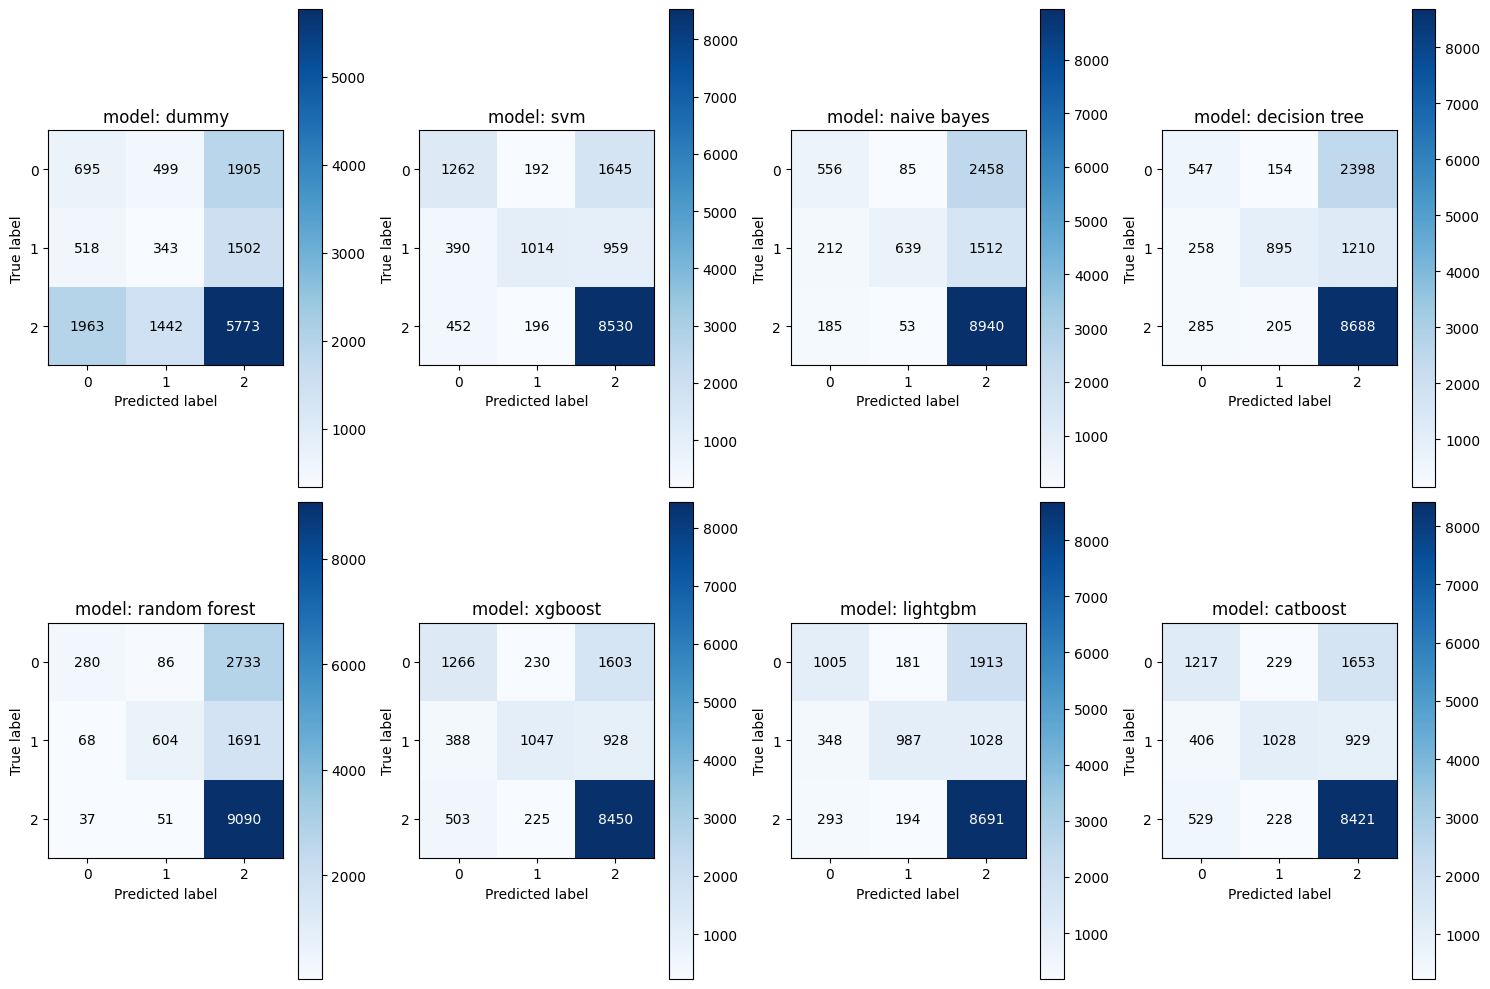

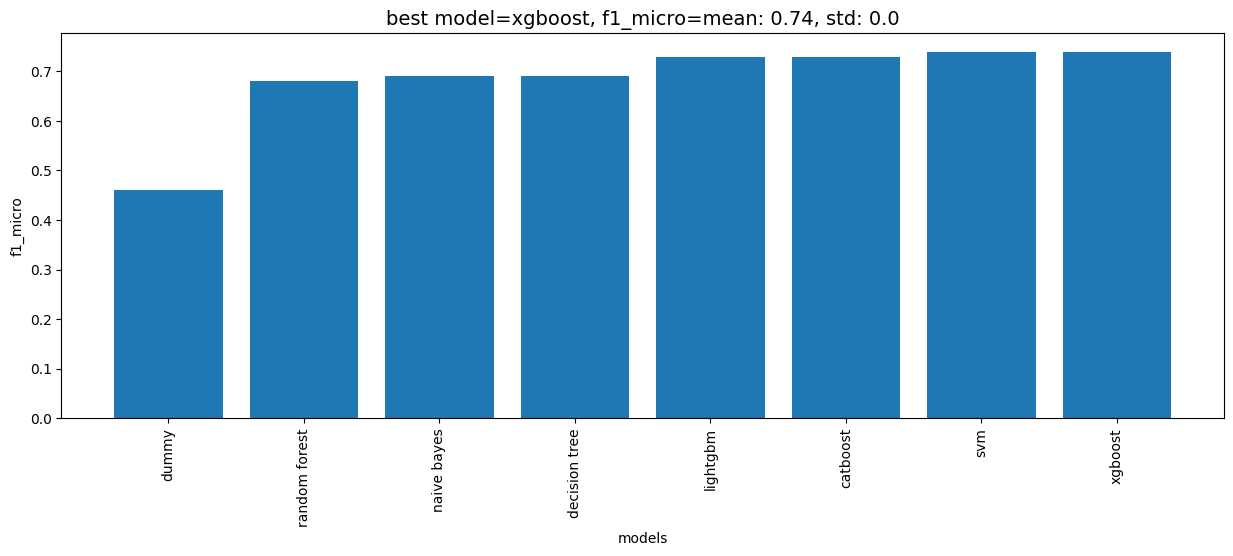

In [11]:
vectorizer_kwargs={'max_features':100}
kwargs = {'scoring': 'f1_micro'}

h.use_vectorizer_and_run_models(X, y, TfidfVectorizer, vectorizer_kwargs, kwargs)